In [1]:
import torch
from sklearn.datasets import make_moons
import pandas as pd
import matplotlib.pyplot as plt

## Generate sample data

In [2]:
X, y = make_moons(
    n_samples = 256,
    noise = 0.1
)

In [3]:
x0 = X[:,0]
x0.shape

(256,)

In [4]:
x1 = X[:, 1]
x1.shape

(256,)

In [5]:
data_dict = dict(x0=x0,x1=x1,y=y)
data_dict.keys()

dict_keys(['x0', 'x1', 'y'])

In [6]:
df = pd.DataFrame(data_dict)

In [7]:
df.head()

,x0,x1,y
0,0.351099,0.886940,0
1,0.680969,0.825130,0
2,-1.116913,0.137029,0
3,1.010401,-0.028492,0
4,-1.039381,0.022900,0


### saving the dataframe in to a csv

In [8]:
df.to_csv("sample_data.csv", index=False)

## Loading the data

In [9]:
data = pd.read_csv("sample_data.csv")
data.head()

,x0,x1,y
0,0.351099,0.886940,0
1,0.680969,0.825130,0
2,-1.116913,0.137029,0
3,1.010401,-0.028492,0
4,-1.039381,0.022900,0


In [10]:
# Creating Training data
data["x0"].head()

0    0.351099
1    0.680969
2   -1.116913
3    1.010401
4   -1.039381
Name: x0, dtype: float64

In [11]:
data["x1"].head()

0    0.886940
1    0.825130
2    0.137029
3   -0.028492
4    0.022900
Name: x1, dtype: float64

In [12]:
# Create a 2D numpy array from the x0 and x1 columns
X_orig = data[["x0","x1"]].to_numpy()

In [13]:
X_orig.shape

(256, 2)

In [14]:
# Create a 1D numpy array from the y column
y_orig = data["y"].to_numpy()

In [15]:
y_orig.shape

(256,)

### Visualizing data

Size X:(256, 2)
Size y:(256,)


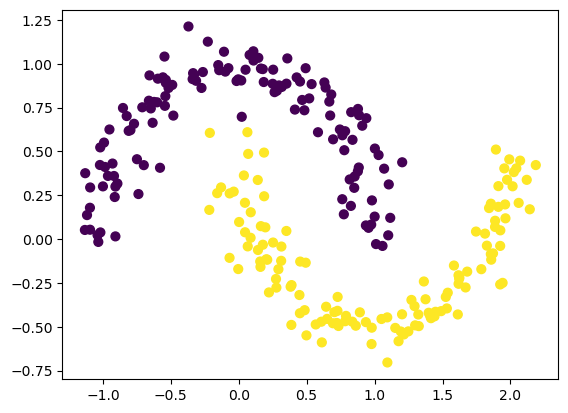

In [16]:
# Print the sizes of the generated 2D points X and the corresponding labels Y
print(f"Size X:{X_orig.shape}")
print(f"Size y:{y_orig.shape}")
# Visualize the dataset. 
# The color of the points is determined by the labels `y_orig`.
plt.scatter(X_orig[:, 0], X_orig[:, 1], s=40, c=y_orig)
plt.show()

### Prepare Data for PyTorch

Now let’s prepare the data in a format suitable for PyTorch - convert everything into tensors.

In [17]:
def set_device():
    """
    Set the device. CUDA if available, CPU otherwise
    
    Args:
    None
    
    Returns:
    Nothing
    """
    # device = "cuda" if torch.cuda.is_available() else "cpu"
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    if device != "mps":
        print("GPU is not enabled in this notebook. \n")
    else:
        print("GPU is enabled in this notebook. \n")
    
    return device

In [18]:
DEVICE = set_device()

GPU is enabled in this notebook. 



In [19]:
# Convert the 2D points to a float32 tensor
X = torch.tensor(X_orig, dtype=torch.float32)

In [20]:
# Upload the tensor to the device
X = X.to(DEVICE)

In [21]:
print(f"Size X:{X.shape}")

Size X:torch.Size([256, 2])


In [22]:
# Convert the labels to a long interger tensor
y = torch.from_numpy(y_orig).type(torch.LongTensor)

# Upload the tensor to the device
y = y.to(DEVICE)

print(f"Size y:{y.shape}")

Size y:torch.Size([256])


In [23]:
# @title Helper function to plot the decision boundary

# Code adapted from this notebook: https://jonchar.net/notebooks/Artificial-Neural-Network-with-Keras/

from pathlib import Path
import numpy as np

def plot_decision_boundary(model, X, y, device):
    """
    Helper function to plot decision boundary
    
    Args:
    model: nn.module
      NaiveNet instance
    X: torch.tensor
      Input CIFAR10 data
    y: torch.tensor
      Class Labels/Targets
    device: String
      "cpu" or "cuda"
    
    Returns:
    Nothing
    """
    # Transfer the data to the CPU
    X = X.cpu().numpy()
    y = y.cpu().numpy()
    
    # Check if the frames folder exists and create it if needed
    frames_path = Path("frames")
    if not frames_path.exists():
        frames_path.mkdir()
    
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole gid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points = torch.from_numpy(grid_points).type(torch.FloatTensor)
    Z = model.predict(grid_points.to(device)).cpu().numpy()
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)
    plt.show()

## Create a Simple Neural Network

For this example we want to have a simple neural network consisting of 3 layers:

- 1 input layer of size 2 (our points have 2 coordinates)

- 1 hidden layer of size 16 (you can play with different numbers here)

- 1 output layer of size 2 (we want the have the scores for the two classes)

### Programing the Network

PyTorch provides a base class for all neural network modules called nn.Module. You need to inherit from nn.Module and implement some important methods:

`__init__`

In the `__init__` method you need to define the structure of your network. Here you will specify what layers will the network consist of, what activation functions will be used etc.

`forward`

All neural network modules need to implement the `forward` method. It specifies the computations the network needs to do when data is passed through it.

`predict`

This is not an obligatory method of a neural network module, but it is a good practice if you want to quickly get the most likely label from the network. It calls the `forward` method and chooses the label with the highest score.

`train`

This is also not an obligatory method, but it is a good practice to have. The method will be used to train the network parameters and will be implemented later in the notebook.

Note: You can use the `__call__` method of a module directly and it will invoke the `forward` method: `net()` does the same as `net.forward()`.

In [24]:
import torch.nn as nn

In [25]:
class NaiveNet(nn.Module):
    """
    NaiveNet architecture
    Structure is as follows:
    Linear Layer (2, 16) -> ReLU activation -> Linear Layer (16, 2)
    """
    # Define the structure of your network
    def __init__(self):
        """
        Defines the NaiveNet structure by initialising following attributes
        nn.Linear (2, 16):  Transformation from the input to the hidden layer
        nn.ReLU: Activation function (ReLU) is a non-linearity which is widely used because it reduces computation.
                 The function returns 0 if it receives any negative input, but for any positive value x, it returns that value back.
        nn.Linear (16, 2): Transformation from the hidden to the output layer
        
        Args:
          None
        
        Returns:
          Nothing
        """
        super(NaiveNet, self).__init__()
        
        # The network is defined as a sequence of operations
        self.layers = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16,2)
        )

    # Specify the computations performed on the data
    def forward(self, x):
        """
        Defines the forward pass through the above defined structure
    
        Args:
          x: torch.Tensor
            Input tensor of size ([3])
    
        Returns:
          layers: nn.module
            Initialised Layers in order to re-use the same layer for each forward pass of data you make.
        """
        # Pass the data through the layers
        return self.layers(x)

    # Choose the most likely label predicted by the network
    def predict(self, x):
        """
        Performs the prediction task of the network
    
        Args:
          x: torch.Tensor
            Input tensor of size ([3])
    
        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)
        # Choose the label with the highest score
        return torch.argmax(output,1)

    # Train the neural network (will be implemented later)
    def train(self, X, y):
        """
            Training the Neural Network
            
            Args:
              X: torch.Tensor
                Input data
              y: torch.Tensor
                Class Labels/Targets
            
            Returns:
              Nothing
        """
        pass



### Check that your network works

Create an instance of your model and visualize it.

In [26]:
model = NaiveNet().to(DEVICE)
print(model)

NaiveNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)


## Exercise
### Classify some samples
Now, let’s pass some of the points of our dataset through the network and see if it works. You should not expect the network to actually classify the points correctly, because it has not been trained yet.

The goal here is just to get some experience with the data structures that are passed to the forward and predict methods and their results.

In [27]:
## Get the samples
X_samples = X[:5, :]
print("Sample input:\n", X_samples)

## Do a forward pass of the network
output = model.forward(X_samples)
print("\nNetwork output:\n", output)

## Predict the label of each point
y_predicted = model.predict(X_samples)
print("\nPredicted labels:\n", y_predicted)

Sample input:
 tensor([[ 0.3511,  0.8869],
        [ 0.6810,  0.8251],
        [-1.1169,  0.1370],
        [ 1.0104, -0.0285],
        [-1.0394,  0.0229]], device='mps:0')

Network output:
 tensor([[-0.0606,  0.1123],
        [-0.0366,  0.1590],
        [-0.2479,  0.0919],
        [ 0.0480,  0.3891],
        [-0.2565,  0.0779]], device='mps:0', grad_fn=<LinearBackward0>)

Predicted labels:
tensor([1, 1, 1, 1, 1], device='mps:0')


In [28]:
# Implement the train function given a training dataset X and correcsponding labels y
def train(self, X, y):
    """
        Training the Neural Network
    
        Args:
          X: torch.Tensor
            Input data
          y: torch.Tensor
            Class Labels/Targets
    
        Returns:
          losses: Float
            Cross Entropy Loss; Cross-entropy builds upon the idea of entropy
            from information theory and calculates the number of bits required
            to represent or transmit an average event from one distribution
            compared to another distribution.
    """
    # The Cross Entropy Loss is suitable for classification problems
    loss_function = nn.CrossEntropyLoss()

    # Create an optimizer (Stochastic Gradient Descent) that will be used to train the network
    learning_rate = 1e-2
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Number of epochs

    epochs = 15000

    # List of losses for viz
    losses = []

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.
        y_logits = model.forward(X)
        loss = loss_function(y_logits, y)

        # Clear the previous gradients and compute the new ones
        optimizer.zero_grad()
        loss.backward()

        # Adapt the weights of the network
        optimizer.step()

        # Store the loss
        losses.append(loss.item())

        # Print the results at every 1000th epoch
        if i%1000 == 0:
            print(f"Epoch {i} loss is {loss.item()}")
            plot_decision_boundary(model,X,y,DEVICE)
            plt.savefig('frames/{:05d}.png'.format(i))
    return losses

In [29]:
# Create a new network instance a train it
model_00 = NaiveNet().to(DEVICE)
model_00

NaiveNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [30]:
X.dtype, y.dtype

(torch.float32, torch.int64)

Epoch 0 loss is 0.6750336289405823


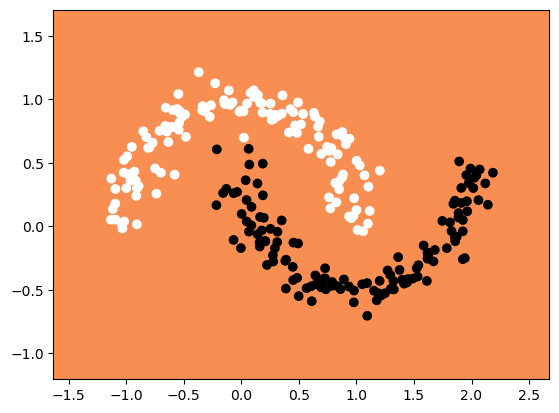

Epoch 1000 loss is 0.26696157455444336


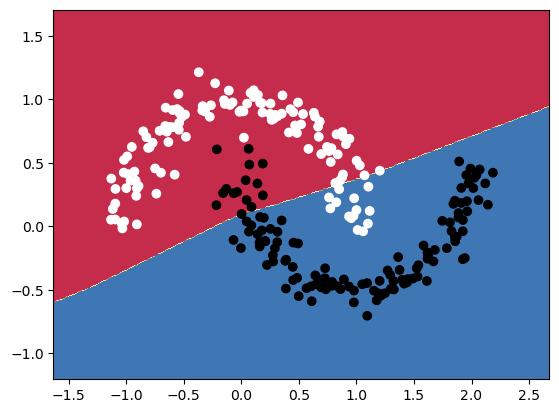

Epoch 2000 loss is 0.23786285519599915


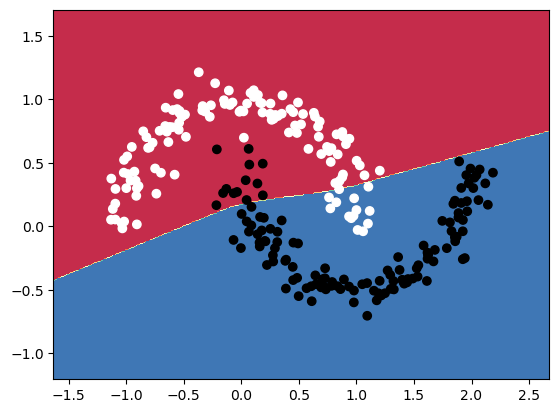

Epoch 3000 loss is 0.2235763967037201


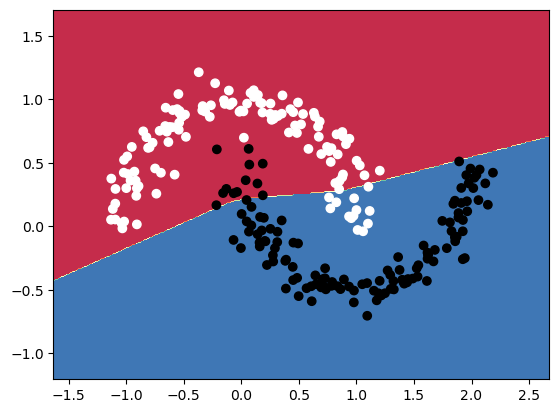

Epoch 4000 loss is 0.21050360798835754


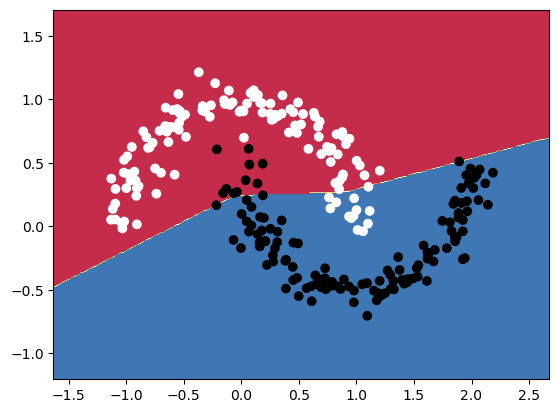

Epoch 5000 loss is 0.19624650478363037


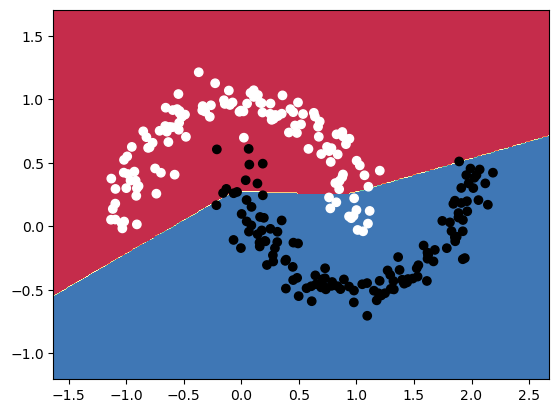

Epoch 6000 loss is 0.18006666004657745


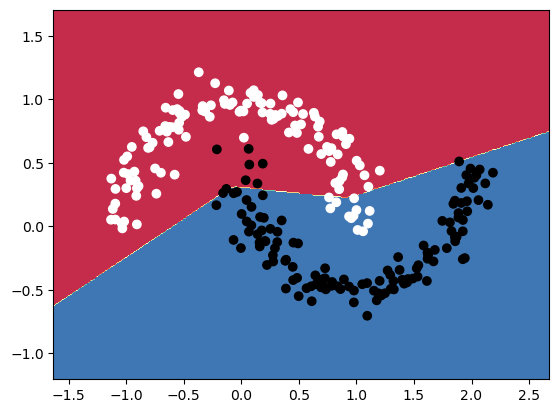

Epoch 7000 loss is 0.1624726951122284


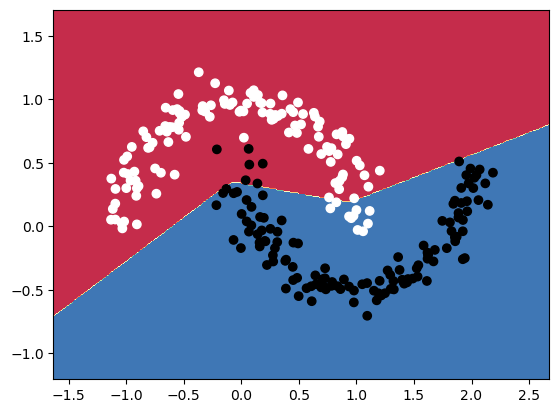

Epoch 8000 loss is 0.14424386620521545


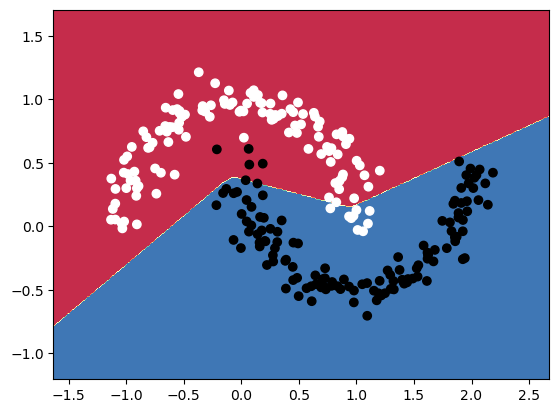

Epoch 9000 loss is 0.1265357881784439


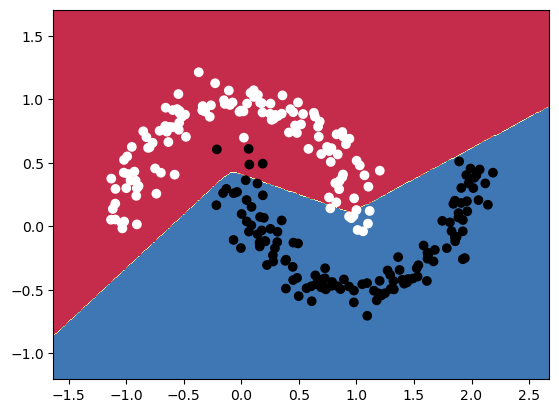

Epoch 10000 loss is 0.11023150384426117


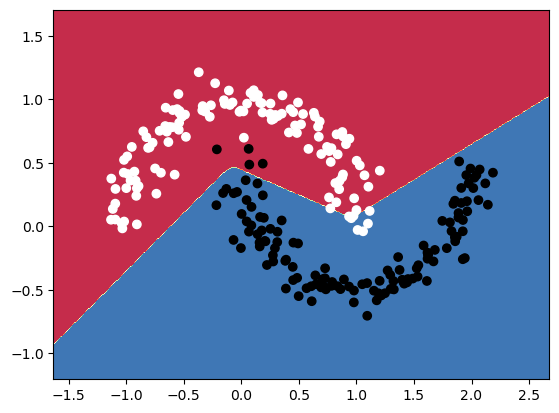

Epoch 11000 loss is 0.09595757722854614


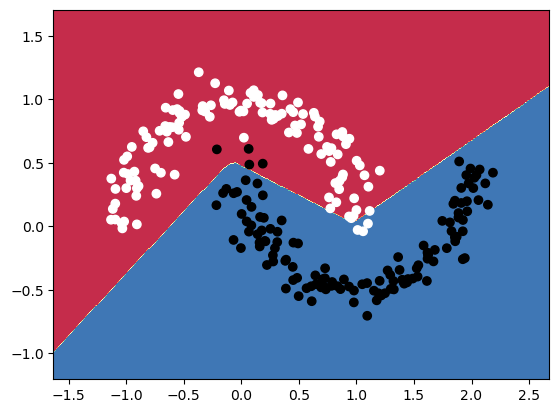

Epoch 12000 loss is 0.08383992314338684


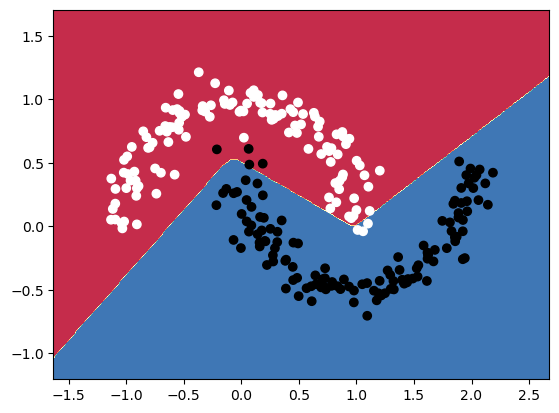

Epoch 13000 loss is 0.07379209995269775


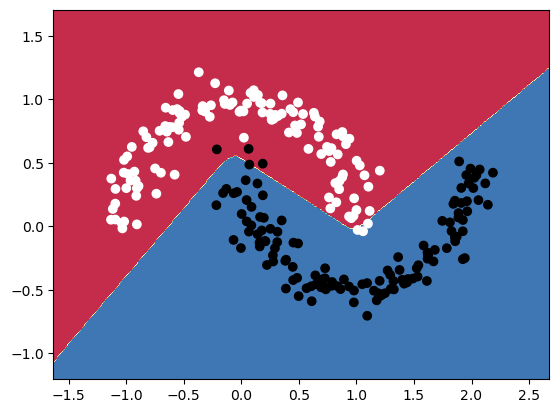

Epoch 14000 loss is 0.06548738479614258


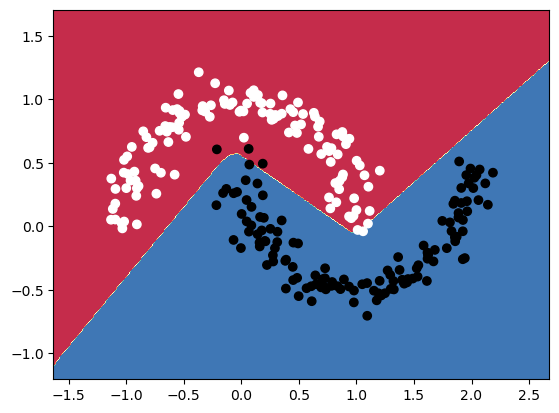

<Figure size 640x480 with 0 Axes>

In [31]:
losses = train(model_00, X, y)

### Plot the loss during training
Plot the loss during the training to see how it reduces and converges.

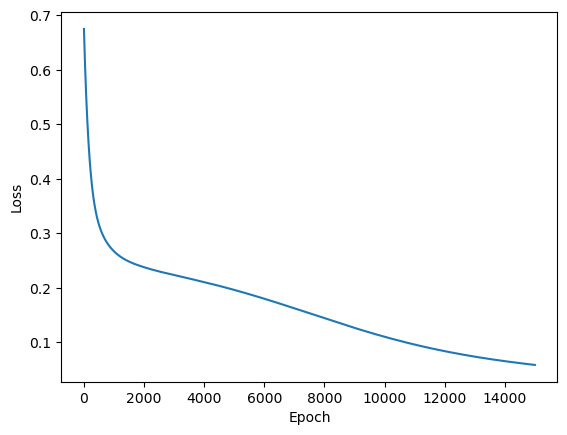

In [32]:
plt.plot(np.linspace(1, len(losses), len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()